# Stable Neural ODEs (*Stable Neural Flows*)

First introduced in [Massaroli, Poli et al, 2020](https://arxiv.org/abs/2003.08063) *Stable Neural FLows* represent a stable variant of Neural ODEs. Their most simple realization has the general neural ODE form

$$
    \begin{aligned}
        &\bf{\dot  z} = -\nabla_z\varepsilon(t, x, z, \theta)\\
        &{\bf z}(0) = h_x(\bf x)
    \end{aligned}
$$

where $\varepsilon(x, z, \theta)$ is a neural network.

They can be used both as general-purpose modules (e.g. classification, continuous normalizing flows) or, thanks to their unique structure, they can be employed to learn dynamical systems in a similar fashion to Lagrangian/Hamiltonian-inspired models

In [1]:
from torchdyn.core import NeuralODE, ODEProblem
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *
import torch
import torch.nn as nn

In [2]:
# quick run for automated notebook validation
dry_run = False

In [3]:
# Vanilla Version of stable neural flows
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out

## Learning Dynamical Systems

Stable neural flows variants in a (autonomous) [port--Hamiltonian](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.366.3380&rep=rep1&type=pdf) form 

$$
    \bf{\dot  z} = F({\bf z})\nabla_z\varepsilon(z)
$$

generalizes the Hamiltonian paradigm to modeling multi-physics systems. They obey to the *power balance equation*

$$
    \frac{d \varepsilon}{d t}  = (\nabla\varepsilon)^\top {\bf F(z)}\nabla\varepsilon
$$

Therefore, if one wants to learn e.g. some conservative process (of any nature), it is sufficient to introduce the inductive bias on $\bf F$ to be a skew-symmetric matrix such that $\dot \varepsilon = 0$. 

Here, we showcase the capibilities of stable neural flows (in port-Hamiltonian form) in such tasks.

In [4]:
# Conservative variant of stable neural flow
class ConservativeStable(nn.Module):
    """Conservative Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        self.M = torch.nn.Parameter(torch.randn(2,2)).to(device)
    
    # impose the system matrix to be skew symmetric
    def Skew(self):
        return .5*(self.M - self.M.T)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out @ self.Skew()

We aim at using a stable neural ODE learning the following conservative nonlinear dynamical system
$$    
    \begin{bmatrix}
        \dot x\\
        \dot v
    \end{bmatrix} =
    \begin{bmatrix}
        v(t)\\
        \pi\left[\cos\left(\pi x(t) - \frac{\pi}{2}\right) - x(t)\right]
    \end{bmatrix} 
$$


In [5]:
# We use this class to simulate through torchdyn the above nonlinear system
class odefunc(nn.Module):
    def __init__(self, sys):
        super().__init__()
        self.sys = sys
    def forward(self, x):
        return self.sys(x)
## nonlinear conservative vector field   
def sys(x):
    dxdt =  x[:,1]
    dydt =  1*np.pi*torch.cos(np.pi*x[:,0]-np.pi/2) - np.pi*x[:,0]# - .5*np.pi*x[:,1]
    return torch.cat([dxdt[:,None], dydt[:,None]], 1)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


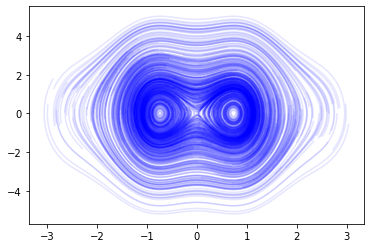

In [6]:
# define the system model just like a neural ODE
system = ODEProblem(odefunc(sys), solver='dopri5')
x0, t_span = torch.randn(1000,2), torch.linspace(0, 2, 100)
# simulate the system
_, traj = system(x0, t_span)

# plot the trajectories
for i in range(len(x0)):
    plt.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=.1)

Train the conservative stable neural flow

In [7]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Data
vf = odefunc(sys)
X = 4*torch.rand(2048,2).to(device)
y = vf(X)
train = data.TensorDataset(X, y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

In [8]:
import pytorch_lightning as pl
import copy
        
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def loss(self, y, y_hat):
        return ((y-y_hat)**2).sum(1).mean()
    
    def training_step(self, batch, batch_idx):
        x = torch.randn(2048,2).to(device)
        y = vf(x)
        y_hat = self.model.vf(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [9]:
# vector field parametrized by a NN
h_dim = 128
f = ConservativeStable(nn.Sequential(
                  nn.Linear(2,h_dim),
                  nn.Tanh(), 
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim, 1)))            

# neural ODE
model = NeuralODE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint').to(device)
seq = nn.Sequential(model).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [10]:
learn = Learner(model)
if dry_run: trainer = pl.Trainer(max_epochs=1, gpus=1)
else: trainer = pl.Trainer(max_epochs=1000, gpus=1)
trainer.fit(learn)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 33.5 K
------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
/home/michael/.cache/pypoetry/virtualenvs/torchdyn-voYSR01p-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'Nominal')

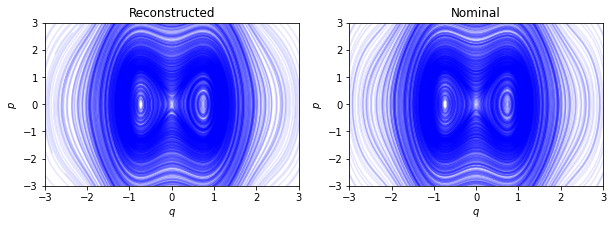

In [11]:
system = system.to(device)
model = model.to(device)

# Sample random initial conditions
X_t = torch.randn(1000, 2).to(device)
# Evaluate the model's trajectories
t_span = torch.linspace(0, 5, 100)
_, sys_traj = system(X_t, t_span)
sys_traj = sys_traj.detach().cpu()
traj = model.trajectory(X_t, t_span).detach().cpu()


# Plot the  trajectories with random ICs
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(X_t)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$p$")
ax.set_title("Reconstructed")


for i in range(len(X_t)):
    ax2.plot(sys_traj[:,i,0], sys_traj[:,i,1], color='blue', alpha=0.1);
ax2.set_xlim([-3,3])
ax2.set_ylim([-3,3])
ax2.set_xlabel(r"$q$")
ax2.set_ylabel(r"$p$")
ax2.set_title("Nominal")

Text(0.5, 1.0, 'Nominal Vector Field')

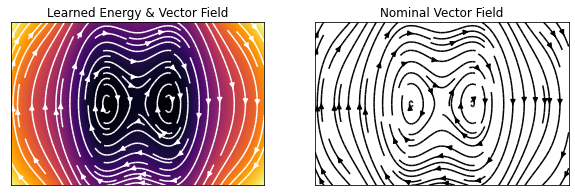

In [26]:
# Compare the learned vector field to the nominal one
import time
fig = plt.figure(figsize=(10,3))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
    
n_grid =  25
q = torch.linspace(-3,3,n_grid)
Q, P = torch.meshgrid(q,q)
H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)
Ur, Vr = torch.zeros(Q.shape), torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        x = torch.cat([Q[i,j].reshape(1,1),P[i,j].reshape(1,1)],1).to(device)
        H[i,j] = f.net(x).detach().cpu()
        O = model.vf(0,x).detach().cpu()
        U[i,j], V[i,j] = O[0,0], O[0,1]
        Ur[i,j], Vr[i,j] = vf(x)[0,0].detach().cpu(), vf(x)[0,1].detach().cpu()

ax0.contourf(Q,P,H,100,cmap='inferno')
ax0.streamplot(Q.T.numpy(),P.T.numpy(),U.T.numpy(),V.T.numpy(), color='white')
ax1.streamplot(Q.T.numpy(),P.T.numpy(),Ur.T.numpy(),Vr.T.numpy(), color='black')
ax0.set_xlim([Q.min(),Q.max()]) ; ax1.set_xlim([Q.min(),Q.max()])
ax0.set_ylim([P.min(),P.max()]) ; ax1.set_ylim([P.min(),P.max()])
ax0.set_xticks([]) ; ax1.set_xticks([])
ax0.set_yticks([]) ; ax1.set_yticks([])
ax0.set_title(f"Learned Energy & Vector Field") ; ax1.set_title("Nominal Vector Field")